## import 및 한글 설정

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision import utils

import os
import matplotlib.pyplot as plt
import unicodedata
import numpy as np
from tqdm import tqdm
from PIL import Image

In [ ]:
plt.rc('font', family='NanumGothic')
plt.rc('font', size=15)

## Mission 2-1
- Mission 1의 결과 분석
  - 맞춘 샘플의 공통점
  - 틀린 샘플의 공통점
  - 맞춘 / 틀린 샘플의 공통점

#### Mission 1 모델 로드 및 정답/오답 이미지 저장

In [ ]:
# GPU가 이용 가능한 경우 "cuda"를, 그렇지 않은 경우 "cpu"를 선택
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미지 변환을 위한 파이토치의 transforms.Compose 사용
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Mission 1의 체크포인트 로드
checkpoint_path = '/content/drive/MyDrive/Mission1.pt'

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 42)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

In [ ]:
# 디렉토리 경로 설정
root_train_dir = '/content/drive/MyDrive/kfood_train_resized/train'
root_val_dir = '/content/drive/MyDrive/kfood_val_resized/val'
save_correct_dir = '/content/drive/MyDrive/correct'
save_incorrect_dir = '/content/drive/MyDrive/incorrect'

# 이미지를 저장할 디렉토리 생성
os.makedirs(save_correct_dir, exist_ok=True)
os.makedirs(save_incorrect_dir, exist_ok=True)

In [ ]:
# 데이터셋 로드
test_dataset = datasets.ImageFolder(root=root_val_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64 , shuffle=False, num_workers=2)

In [ ]:
# 클래스 인덱스를 클래스 이름으로 매핑하는 딕셔너리 생성
idx_to_class = {v: k for k,v in test_dataset.class_to_idx.items()}

class_names = os.listdir(root_train_dir)

# 정답/오답 개수를 저장할 딕셔너리
correct_counter = {}
incorrect_counter = {}

# 딕셔너리 초기화
for class_name in class_names:
    correct_counter[class_name] = 0
    incorrect_counter[class_name] = 0

def unnormalize(img):
    img_copy = img.clone()  # 원본 데이터를 변경하지 않도록 복사
    img_copy[0] *= 0.229; img_copy[0] += 0.485;
    img_copy[1] *= 0.224; img_copy[1] += 0.456;
    img_copy[2] *= 0.225; img_copy[2] += 0.406;
    return img_copy

with torch.no_grad(), tqdm(total=len(test_loader), desc="Saving Correct/Incorrect Images") as pbar:
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # 가장 높은 확률을 가진 클래스를 선택
        _, preds = outputs.max(1)

        # 정답과 예측이 다른 경우를 식별
        incorrect_mask = preds != labels

        # 각 이미지에 대해 틀린 예측을 처리
        for i in range(len(incorrect_mask)):
            if incorrect_mask[i]:
                # 틀린 클래스, 정답 클래스
                incorrect_label = preds[i].item()
                correct_label = labels[i].item()

                # 해당 클래스에 대한 틀린 예측 수를 증가시킵니다.
                incorrect_counter[idx_to_class[correct_label]] += 1

                # 틀린 이미지를 저장할 디렉토리를 생성합니다.
                class_dir = os.path.join(save_incorrect_dir, idx_to_class[correct_label])
                os.makedirs(class_dir, exist_ok=True)

                image_filename = f'incorrect_{i}_pred_{idx_to_class[incorrect_label]}_actual_{idx_to_class[correct_label]}.png'
                image_path = os.path.join(class_dir, image_filename)

                # 정규화 해제 후 저장
                utils.save_image(unnormalize(inputs[i].cpu()), image_path)
            else:
                # 정답 클래스
                correct_label = preds[i].item()

                # 해당 클래스에 대한 맞춘 예측 수를 증가시킵니다.
                correct_counter[idx_to_class[correct_label]] += 1

                # 맞춘 이미지를 저장할 디렉토리를 생성합니다.
                class_dir = os.path.join(save_correct_dir, idx_to_class[correct_label])
                os.makedirs(class_dir, exist_ok=True)

                image_filename = f'correct_{i}_pred_{idx_to_class[correct_label]}_actual_{idx_to_class[correct_label]}.png'
                image_path = os.path.join(class_dir, image_filename)

                # 정규화 해제 후 저장
                utils.save_image(unnormalize(inputs[i].cpu()), image_path)

        pbar.update(1)

Saving Correct/Incorrect Images: 100%|██████████| 66/66 [01:46<00:00,  1.61s/it]


#### 클래스별 정답/오답 비율 시각화



In [ ]:
# 각 서브폴더에 있는 파일의 개수를 세는 함수
def count_files_in_subfolders(root_folder):
    subfolder_names = os.listdir(root_folder)
    subfolder_info = []

    for subfolder_name in subfolder_names:
        subfolder_path = os.path.join(root_folder, subfolder_name)
        if os.path.isdir(subfolder_path):
            num_files = len(os.listdir(subfolder_path))
            subfolder_info.append([subfolder_name, num_files])

    return dict(subfolder_info)

val_counts = list(count_files_in_subfolders(root_val_dir).values())

- 상위 3개 정분류 클래스
  - 맞춘 비율 : 맞춘 개수 / 클래스 이미지 수
  - 1위 : 잡곡밥 - 68.9%
  - 2위 : 미역국 - 62.2%
  - 3위 : 육개장 - 62.2%

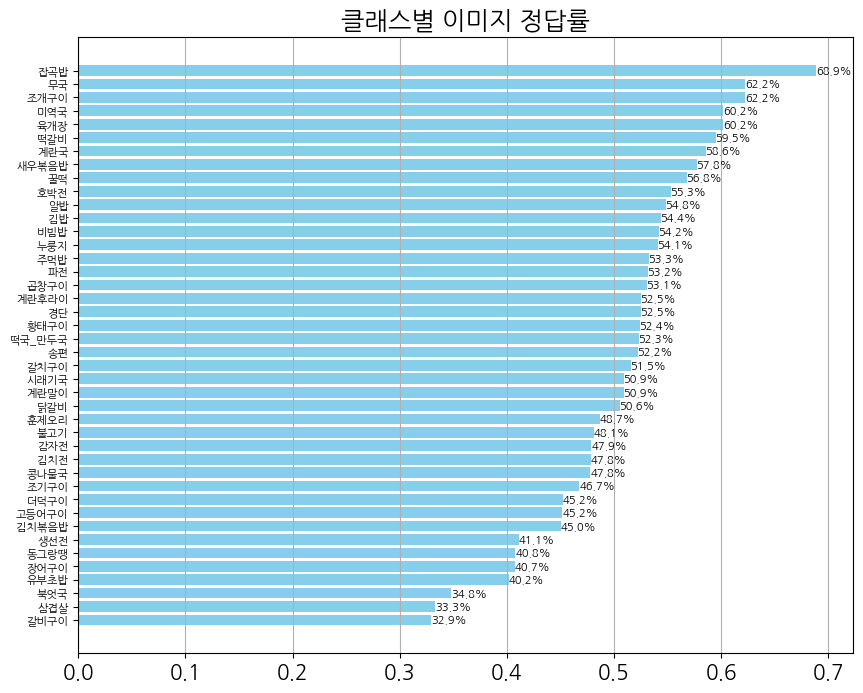

In [ ]:
# 각 클래스별 디렉토리 경로 가져오기
folder_paths = [os.path.join(save_correct_dir, folder) for folder in os.listdir(save_correct_dir)]
image_counts = dict(sorted([(os.path.basename(folder), len(os.listdir(folder))) for folder in folder_paths], key=lambda x: x[0]))
image_counts_div_val_counts = {key: value / val_counts[i] for i, (key, value) in enumerate(image_counts.items())}

sorted_image_counts = dict(sorted(image_counts_div_val_counts.items(), key=lambda x: x[1], reverse=False))
class_normalized_names = [unicodedata.normalize('NFC', name) for name in sorted_image_counts.keys()]


plt.figure(figsize=(10, 8))

# 수평 바 그래프로 시각화
bars = plt.barh(class_normalized_names, list(sorted_image_counts.values()), color='skyblue')

# y축 값들의 폰트 크기 조정
plt.yticks(fontsize=8)

# y축 라벨과 제목 추가
plt.title('클래스별 이미지 정답률')

# x축을 정수로 표시
plt.xticks(np.arange(0, max(sorted_image_counts.values()) + 0.1, 0.1))

# 그리드 추가
plt.grid(axis='x')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.1%}',
             va='center', ha='left', fontsize=8, color='black')

# 그래프 표시
plt.show()

- 상위 3개 오분류 클래스
  - 틀린 비율 : 틀린 개수 / 클래스 이미지 수
  - 1위 : 삼겹살 - 57.6%
  - 2위 : 생선전 - 55.0%
  - 3위 : 갈비구이 - 49.5%

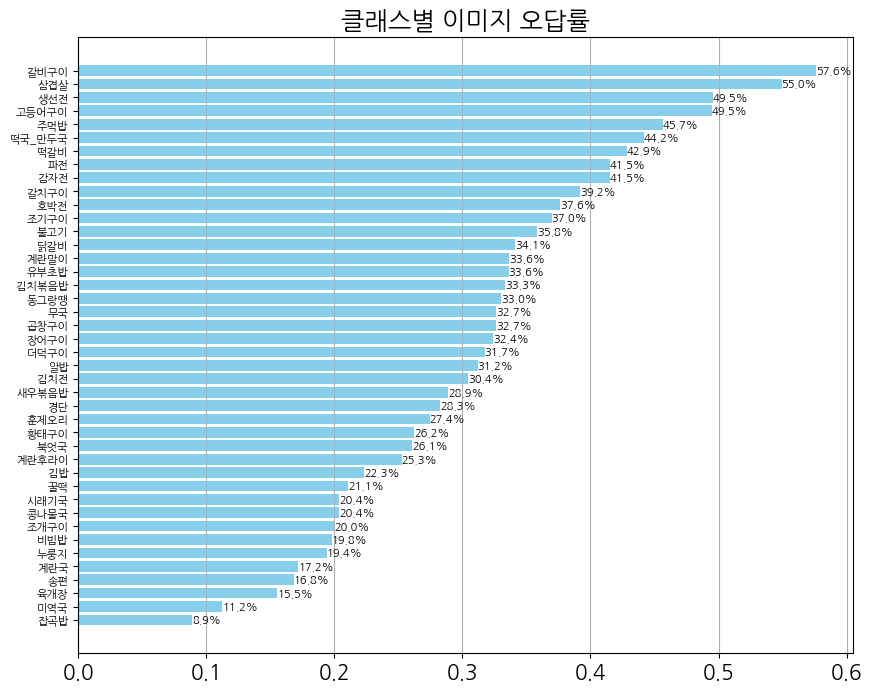

In [ ]:
# 각 클래스별 디렉토리 경로 가져오기
folder_paths = [os.path.join(save_incorrect_dir, folder) for folder in os.listdir(save_incorrect_dir)]
image_counts = dict(sorted([(os.path.basename(folder), len(os.listdir(folder))) for folder in folder_paths], key=lambda x: x[0]))
image_counts_div_val_counts = {key: value / val_counts[i] for i, (key, value) in enumerate(image_counts.items())}

sorted_image_counts = dict(sorted(image_counts_div_val_counts.items(), key=lambda x: x[1], reverse=False))
class_normalized_names = [unicodedata.normalize('NFC', name) for name in sorted_image_counts.keys()]


plt.figure(figsize=(10, 8))

# 수평 바 그래프로 시각화
bars = plt.barh(class_normalized_names, list(sorted_image_counts.values()), color='skyblue')

# y축 값들의 폰트 크기 조정
plt.yticks(fontsize=8)

# y축 라벨과 제목 추가
plt.title('클래스별 이미지 오답률')

# x축을 정수로 표시
plt.xticks(np.arange(0, max(sorted_image_counts.values()) + 0.1, 0.1))

# 그리드 추가
plt.grid(axis='x')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.1%}',
             va='center', ha='left', fontsize=8, color='black')

# 그래프 표시
plt.show()

#### TOP3 정분류 샘플 시각화

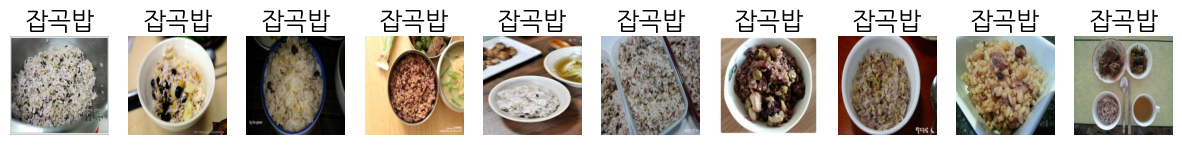

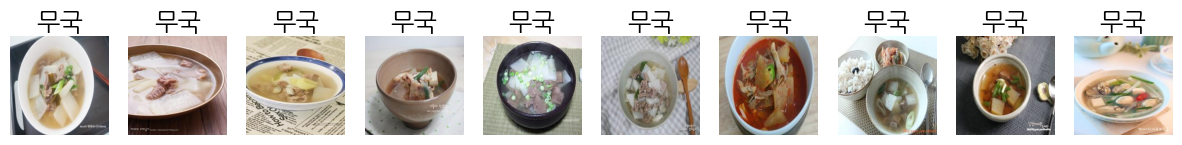

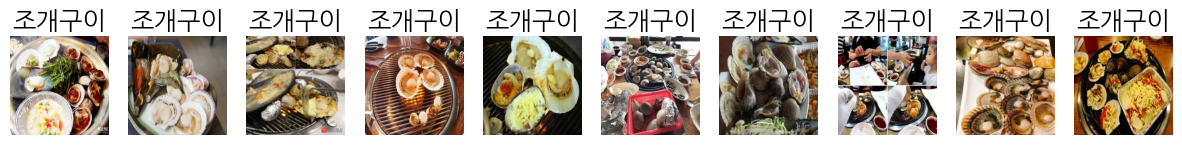

In [ ]:
# 각 클래스별 디렉토리 경로 가져오기
folder_paths = [os.path.join(save_correct_dir, folder) for folder in os.listdir(save_correct_dir)]
image_counts = dict(sorted([(os.path.basename(folder), len(os.listdir(folder))) for folder in folder_paths], key=lambda x: x[0]))
image_counts_div_val_counts = {key: value / val_counts[i] for i, (key, value) in enumerate(image_counts.items())}

sorted_image_counts = sorted(image_counts_div_val_counts.items(), key=lambda x: x[1], reverse=True)

# 상위 3개 클래스에 대해 각각 상위 10개 이미지 시각화
for class_name, _ in sorted_image_counts[:3]:
    class_directory = os.path.join(save_correct_dir, class_name)
    class_normalized_name = unicodedata.normalize('NFC', class_name)

    # class_directory에서 상위 10개 이미지 파일 경로 가져오기
    image_file_paths = [os.path.join(class_directory, f) for f in os.listdir(class_directory)[:10]]

    # 이미지 시각화
    fig, axes = plt.subplots(1, 10, figsize=(15, 7))
    for i, ax in enumerate(axes.flat):
        image = Image.open(image_file_paths[i])
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'{class_normalized_name}')

    plt.show()

#### TOP3 오분류 샘플 시각화

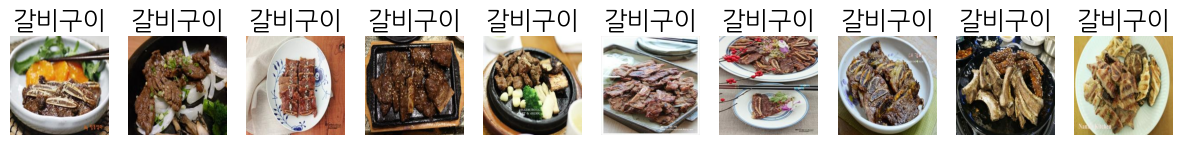

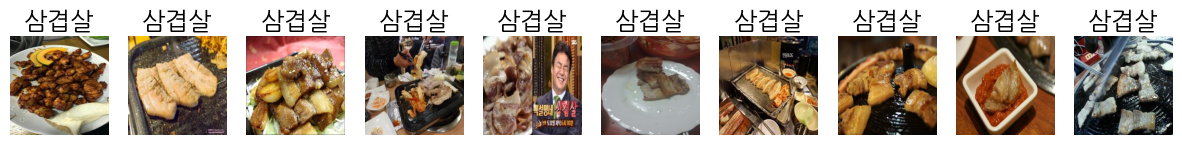

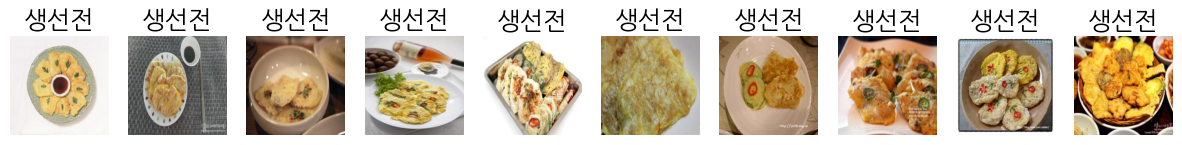

In [ ]:
# 각 클래스별 디렉토리 경로 가져오기
folder_paths = [os.path.join(save_incorrect_dir, folder) for folder in os.listdir(save_incorrect_dir)]
image_counts = dict(sorted([(os.path.basename(folder), len(os.listdir(folder))) for folder in folder_paths], key=lambda x: x[0]))
image_counts_div_val_counts = {key: value / val_counts[i] for i, (key, value) in enumerate(image_counts.items())}

sorted_image_counts = sorted(image_counts_div_val_counts.items(), key=lambda x: x[1], reverse=True)

# 상위 3개 클래스에 대해 각각 상위 10개 이미지 시각화
for class_name, _ in sorted_image_counts[:3]:
    class_directory = os.path.join(save_incorrect_dir, class_name)
    class_normalized_name = unicodedata.normalize('NFC', class_name)

    # class_directory에서 상위 10개 이미지 파일 경로 가져오기
    image_file_paths = [os.path.join(class_directory, f) for f in os.listdir(class_directory)[:10]]

    # 이미지 시각화
    fig, axes = plt.subplots(1, 10, figsize=(15, 7))
    for i, ax in enumerate(axes.flat):
        image = Image.open(image_file_paths[i])
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'{class_normalized_name}')

    plt.show()

## Mission 2-2
- 2-1의 분석을 기반으로 성능 향상을 위한 작업을 수행

### device 및 transform 설정

In [ ]:
# 이미지 증강 기법 중 하나인 Cutout 적용
class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = int(np.clip(y - self.length // 2, 0, h))
            y2 = int(np.clip(y + self.length // 2, 0, h))
            x1 = int(np.clip(x - self.length // 2, 0, w))
            x2 = int(np.clip(x + self.length // 2, 0, w))

            mask[y1: y2,x1: x2] = 0.

        mask=torch.from_numpy(mask)
        mask=mask.expand_as(img)

        return img*mask

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train 데이터의 transform 설정
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # 랜덤 224로 자르기
    transforms.RandomHorizontalFlip(),  # 랜덤 반전
    transforms.ToTensor(),  # image를 tesnsor로 변경
    transforms.RandomRotation(degrees=15), # 회전 추가
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 이미지 데이터 정규화
    Cutout(n_holes=1,length=16) # 노이즈 추가
])

# val 데이터의 transform 설정
val_transform = transforms.Compose([
    transforms.Resize(256),  # 256x256으로 resize
    transforms.CenterCrop(224),  # 224x224로 자르기
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### 데이터 로드

In [ ]:
# 데이터셋 로드
train_dataset = datasets.ImageFolder(root='/content/kfood_train_resized/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='/content/kfood_val_resized/val', transform=val_transform)

# 데이터로더 설정
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

### 모델(resnet50) 설정

In [ ]:
# 모델 설정
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 42)
model = model.to(device)

Training dataset size: 33792
Validation dataset size: 4198


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### 손실함수, 최적화 함수 설정
- 클래스별 가중치 계산해 데이터 불균형 해결

In [ ]:
class_counts = [809, 810, 803, 803, 796, 793, 812, 803, 789, 789, 806, 791, 807, 799, 810, 797, 815, 819, 983, 773, 798, 799, 796, 800, 791, 791, 801, 802, 802, 797, 805, 788, 802, 799, 803, 802, 779, 818, 814, 797, 805, 796]

# 전체 크기 계산
total_size = sum(class_counts)

# 각 클래스에 대한 가중치를 계산하여 리스트에 저장
class_weights = [total_size / count for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Cross-Entropy Loss 를 사용, 클래스 가중치 적용
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)

### 학습 함수

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        wandb.log({"train_loss": loss.item()})

    return running_loss / len(train_loader.dataset)

### 평가 함수

In [ ]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    average_loss = running_loss / len(val_loader.dataset)
    accuracy = (correct_predictions / total_predictions) * 100

    return average_loss, accuracy

### 체크포인트로 모델 로드

In [ ]:
start_epoch = 0  # 시작 에포크 초기값 설정
best_acc = 0.0  # 최고 정확도 초기값 설정
save_path = "/content/drive/MyDrive/Mission2.pt"

# 체크포인트 파일이 존재하는지 확인 후, 로드
try:
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_acc = checkpoint['best_acc']
    print(f"Loaded checkpoint from epoch {start_epoch}, best accuracy was {best_acc:.2f}%")
except FileNotFoundError:
    print("No checkpoint file found, starting training from scratch.")

No checkpoint file found, starting training from scratch.


### 학습 및 평가
- 성능이 꾸준히 증가하며 에포크 60에서 최고 정확도 82.4% 달성
- 정확도가 수렴하지 않아 학습이 더 가능할 것이라 판단하여 추가 학습 시도

In [ ]:
for epoch in range(start_epoch, 60):
    # 모델을 훈련 데이터로 훈련, 손실 값 계산
    train_loss = train(model, train_loader, criterion, optimizer, device)

    # 검증 데이터로 모델을 평가, 검증 손실 및 정확도 계산
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{60} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

    # 현재 정확도가 최고 정확도보다 높으면 저장
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
        }, save_path)

Training:   0%|          | 0/528 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training: 100%|██████████| 528/528 [06:07<00:00,  1.44it/s]


Epoch 1/60 - Train Loss: 3.1828 - Val Loss: 2.8929 - Val Acc: 19.82%


Training: 100%|██████████| 528/528 [05:57<00:00,  1.48it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 2/60 - Train Loss: 2.7784 - Val Loss: 2.5330 - Val Acc: 28.56%


Training: 100%|██████████| 528/528 [06:01<00:00,  1.46it/s]


Epoch 3/60 - Train Loss: 2.4870 - Val Loss: 2.5310 - Val Acc: 30.82%


Training: 100%|██████████| 528/528 [06:01<00:00,  1.46it/s]


Epoch 4/60 - Train Loss: 2.2179 - Val Loss: 2.1269 - Val Acc: 38.59%


Training: 100%|██████████| 528/528 [06:00<00:00,  1.46it/s]


Epoch 5/60 - Train Loss: 2.0473 - Val Loss: 1.9069 - Val Acc: 43.50%


Training: 100%|██████████| 528/528 [06:01<00:00,  1.46it/s]


Epoch 6/60 - Train Loss: 1.9157 - Val Loss: 1.7401 - Val Acc: 48.26%


Training: 100%|██████████| 528/528 [06:00<00:00,  1.46it/s]


Epoch 7/60 - Train Loss: 1.7829 - Val Loss: 1.5063 - Val Acc: 54.38%


Training: 100%|██████████| 528/528 [06:02<00:00,  1.46it/s]


Epoch 8/60 - Train Loss: 1.6840 - Val Loss: 1.4992 - Val Acc: 55.65%


Training: 100%|██████████| 528/528 [06:02<00:00,  1.46it/s]


Epoch 9/60 - Train Loss: 1.6014 - Val Loss: 1.4627 - Val Acc: 55.36%


Training: 100%|██████████| 528/528 [06:01<00:00,  1.46it/s]


Epoch 10/60 - Train Loss: 1.5142 - Val Loss: 1.2841 - Val Acc: 61.34%


Training: 100%|██████████| 528/528 [06:00<00:00,  1.47it/s]


Epoch 11/60 - Train Loss: 1.4510 - Val Loss: 1.2793 - Val Acc: 61.15%


Training: 100%|██████████| 528/528 [06:01<00:00,  1.46it/s]


Epoch 12/60 - Train Loss: 1.3996 - Val Loss: 1.2224 - Val Acc: 61.82%


Training: 100%|██████████| 528/528 [06:00<00:00,  1.47it/s]


Epoch 13/60 - Train Loss: 1.3289 - Val Loss: 1.1154 - Val Acc: 65.72%


Training: 100%|██████████| 528/528 [06:00<00:00,  1.47it/s]


Epoch 14/60 - Train Loss: 1.2763 - Val Loss: 1.1127 - Val Acc: 66.53%


Training: 100%|██████████| 528/528 [06:01<00:00,  1.46it/s]


Epoch 15/60 - Train Loss: 1.2367 - Val Loss: 1.0611 - Val Acc: 67.68%


Training: 100%|██████████| 528/528 [06:00<00:00,  1.47it/s]


Epoch 16/60 - Train Loss: 1.1999 - Val Loss: 1.1196 - Val Acc: 66.22%


Training: 100%|██████████| 528/528 [05:59<00:00,  1.47it/s]


Epoch 17/60 - Train Loss: 1.1627 - Val Loss: 1.0069 - Val Acc: 69.41%


Training: 100%|██████████| 528/528 [06:00<00:00,  1.46it/s]


Epoch 18/60 - Train Loss: 1.1296 - Val Loss: 0.9969 - Val Acc: 69.65%


Training: 100%|██████████| 528/528 [05:59<00:00,  1.47it/s]


Epoch 19/60 - Train Loss: 1.0915 - Val Loss: 0.9476 - Val Acc: 71.84%


Training: 100%|██████████| 528/528 [06:00<00:00,  1.47it/s]


Epoch 20/60 - Train Loss: 1.0732 - Val Loss: 0.9202 - Val Acc: 71.70%


Training: 100%|██████████| 528/528 [06:02<00:00,  1.46it/s]


Epoch 21/60 - Train Loss: 1.0438 - Val Loss: 0.8506 - Val Acc: 73.96%


Training: 100%|██████████| 528/528 [06:02<00:00,  1.46it/s]


Epoch 22/60 - Train Loss: 1.0169 - Val Loss: 0.8581 - Val Acc: 74.11%


Training: 100%|██████████| 528/528 [06:01<00:00,  1.46it/s]


Epoch 23/60 - Train Loss: 0.9782 - Val Loss: 0.8712 - Val Acc: 73.61%


Training: 100%|██████████| 528/528 [05:59<00:00,  1.47it/s]


Epoch 24/60 - Train Loss: 0.9580 - Val Loss: 0.8790 - Val Acc: 73.73%


Training: 100%|██████████| 528/528 [06:02<00:00,  1.46it/s]


Epoch 25/60 - Train Loss: 0.9351 - Val Loss: 0.8450 - Val Acc: 74.15%


Training: 100%|██████████| 528/528 [06:03<00:00,  1.45it/s]


Epoch 26/60 - Train Loss: 0.9017 - Val Loss: 0.8053 - Val Acc: 76.66%


Training: 100%|██████████| 528/528 [06:02<00:00,  1.46it/s]


Epoch 27/60 - Train Loss: 0.8805 - Val Loss: 0.7593 - Val Acc: 76.42%


Training: 100%|██████████| 528/528 [06:01<00:00,  1.46it/s]


Epoch 28/60 - Train Loss: 0.8535 - Val Loss: 0.7754 - Val Acc: 76.85%


Training: 100%|██████████| 528/528 [06:00<00:00,  1.46it/s]


Epoch 29/60 - Train Loss: 0.8417 - Val Loss: 0.7748 - Val Acc: 76.70%


Training: 100%|██████████| 528/528 [06:01<00:00,  1.46it/s]


Epoch 30/60 - Train Loss: 0.8131 - Val Loss: 0.7679 - Val Acc: 76.73%


Training: 100%|██████████| 528/528 [05:59<00:00,  1.47it/s]


Epoch 31/60 - Train Loss: 0.8013 - Val Loss: 0.7643 - Val Acc: 77.23%


Training: 100%|██████████| 528/528 [05:59<00:00,  1.47it/s]


Epoch 32/60 - Train Loss: 0.7756 - Val Loss: 0.7823 - Val Acc: 76.92%


Training: 100%|██████████| 528/528 [05:59<00:00,  1.47it/s]


Epoch 33/60 - Train Loss: 0.7720 - Val Loss: 0.7775 - Val Acc: 77.20%


Training: 100%|██████████| 528/528 [06:00<00:00,  1.46it/s]


Epoch 34/60 - Train Loss: 0.7476 - Val Loss: 0.7404 - Val Acc: 78.30%


Training: 100%|██████████| 528/528 [06:02<00:00,  1.46it/s]


Epoch 35/60 - Train Loss: 0.7335 - Val Loss: 0.8231 - Val Acc: 76.01%


Training: 100%|██████████| 528/528 [06:03<00:00,  1.45it/s]


Epoch 36/60 - Train Loss: 0.7228 - Val Loss: 0.7463 - Val Acc: 78.39%


Training: 100%|██████████| 528/528 [05:58<00:00,  1.47it/s]


Epoch 37/60 - Train Loss: 0.7018 - Val Loss: 0.7375 - Val Acc: 78.82%


Training: 100%|██████████| 528/528 [06:04<00:00,  1.45it/s]


Epoch 38/60 - Train Loss: 0.6835 - Val Loss: 0.7692 - Val Acc: 77.80%


Training: 100%|██████████| 528/528 [06:03<00:00,  1.45it/s]


Epoch 39/60 - Train Loss: 0.6680 - Val Loss: 0.7867 - Val Acc: 77.61%


Training: 100%|██████████| 528/528 [06:04<00:00,  1.45it/s]


Epoch 40/60 - Train Loss: 0.6652 - Val Loss: 0.7080 - Val Acc: 79.49%


Training: 100%|██████████| 528/528 [06:03<00:00,  1.45it/s]


Epoch 41/60 - Train Loss: 0.6533 - Val Loss: 0.7178 - Val Acc: 78.97%


Training: 100%|██████████| 528/528 [06:03<00:00,  1.45it/s]


Epoch 42/60 - Train Loss: 0.6248 - Val Loss: 0.6695 - Val Acc: 80.82%


Training: 100%|██████████| 528/528 [06:03<00:00,  1.45it/s]


Epoch 43/60 - Train Loss: 0.6184 - Val Loss: 0.6886 - Val Acc: 80.51%


Training: 100%|██████████| 528/528 [06:01<00:00,  1.46it/s]


Epoch 44/60 - Train Loss: 0.6027 - Val Loss: 0.7388 - Val Acc: 78.82%


Training: 100%|██████████| 528/528 [06:05<00:00,  1.44it/s]


Epoch 45/60 - Train Loss: 0.5866 - Val Loss: 0.7047 - Val Acc: 80.54%


Training: 100%|██████████| 528/528 [06:05<00:00,  1.44it/s]


Epoch 46/60 - Train Loss: 0.5818 - Val Loss: 0.7254 - Val Acc: 80.66%


Training: 100%|██████████| 528/528 [06:05<00:00,  1.45it/s]


Epoch 47/60 - Train Loss: 0.5668 - Val Loss: 0.7009 - Val Acc: 80.20%


Training: 100%|██████████| 528/528 [06:03<00:00,  1.45it/s]


Epoch 48/60 - Train Loss: 0.5567 - Val Loss: 0.6556 - Val Acc: 82.06%


Training: 100%|██████████| 528/528 [06:04<00:00,  1.45it/s]


Epoch 49/60 - Train Loss: 0.5431 - Val Loss: 0.6906 - Val Acc: 81.30%


Training: 100%|██████████| 528/528 [06:03<00:00,  1.45it/s]


Epoch 50/60 - Train Loss: 0.5352 - Val Loss: 0.6698 - Val Acc: 81.35%


Training: 100%|██████████| 528/528 [06:00<00:00,  1.46it/s]


Epoch 51/60 - Train Loss: 0.5302 - Val Loss: 0.6373 - Val Acc: 82.40%


Training: 100%|██████████| 528/528 [06:00<00:00,  1.47it/s]


Epoch 52/60 - Train Loss: 0.5137 - Val Loss: 0.7146 - Val Acc: 80.85%


Training: 100%|██████████| 528/528 [06:03<00:00,  1.45it/s]


Epoch 53/60 - Train Loss: 0.5089 - Val Loss: 0.7307 - Val Acc: 80.82%


Training: 100%|██████████| 528/528 [06:04<00:00,  1.45it/s]


Epoch 54/60 - Train Loss: 0.4886 - Val Loss: 0.7162 - Val Acc: 81.44%


Training: 100%|██████████| 528/528 [06:03<00:00,  1.45it/s]


Epoch 55/60 - Train Loss: 0.4944 - Val Loss: 0.6525 - Val Acc: 81.75%


Training: 100%|██████████| 528/528 [06:04<00:00,  1.45it/s]


Epoch 56/60 - Train Loss: 0.4815 - Val Loss: 0.6670 - Val Acc: 82.18%


Training: 100%|██████████| 528/528 [06:05<00:00,  1.44it/s]


Epoch 57/60 - Train Loss: 0.4761 - Val Loss: 0.7132 - Val Acc: 81.11%


Training: 100%|██████████| 528/528 [06:03<00:00,  1.45it/s]


Epoch 58/60 - Train Loss: 0.4650 - Val Loss: 0.6789 - Val Acc: 81.92%


Training: 100%|██████████| 528/528 [06:04<00:00,  1.45it/s]


Epoch 59/60 - Train Loss: 0.4623 - Val Loss: 0.6563 - Val Acc: 82.18%


Training: 100%|██████████| 528/528 [06:03<00:00,  1.45it/s]


Epoch 60/60 - Train Loss: 0.4519 - Val Loss: 0.6876 - Val Acc: 82.44%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▇▆▆▅▅▅▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▂▁▂▂
val_acc,▁▂▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇██████████████
val_loss,█▇▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,59
train_loss,0.45192
val_acc,82.44402
val_loss,0.6876


### 체크포인트로 모델 로드
- 위에서 학습한 60 에포크 모델 로드

In [ ]:
save_path = "/content/drive/MyDrive/Mission2.pt"

checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
best_acc = checkpoint['best_acc']
best_acc

82.44402096236303

### LR 변경 및 모델 로드

- 0.001 -> 0.0005

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
start_epoch = 0
best_acc = 0.0
save_path = "/content/drive/MyDrive/Mission2.pt"

# 체크포인트 파일이 존재하는지 확인 후, 로드
try:
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_acc = checkpoint['best_acc']
    print(f"Loaded checkpoint from epoch {start_epoch}, best accuracy was {best_acc:.2f}%")
except FileNotFoundError:
    print("No checkpoint file found, starting training from scratch.")


Loaded checkpoint from epoch 60, best accuracy was 82.44%


### 조기 종료 적용
  - 5번 동안 accuracy 개선되지 않으면 조기 종료
  - 에포크 63에서 정확도 83.66% 기록 후 에포크 67에서 조기 종료

In [ ]:
# 몇 번의 에포크 동안 성능 개선이 없었는지 저장하는 변수
patience = 5

# 성능 개선이 없는 에폭 수 저장하는 변수
early_stopping_counter = 0

for epoch in range(start_epoch, 80):
    # 모델을 훈련 데이터로 훈련, 손실 값 계산
    train_loss = train(model, train_loader, criterion, optimizer, device)

    # 검증 데이터로 모델을 평가, 검증 손실 및 정확도 계산
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{80} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

    # 현재 정확도가 최고 정확도보다 높으면 저장
    if val_acc > best_acc:
        best_acc = val_acc
        early_stopping_counter = 0

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
        }, '/content/drive/MyDrive/Mission2.pt')

    else:
      # 성능 개선이 없는 에포크 수 증가
      early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print(f"Early stopping! No improvement in validation accuracy for {patience} epochs.")
        break

Training: 100%|██████████| 528/528 [05:38<00:00,  1.56it/s]


Epoch 61/80 - Train Loss: 0.4319 - Val Loss: 0.6825 - Val Acc: 82.97%


Training: 100%|██████████| 528/528 [05:42<00:00,  1.54it/s]


Epoch 62/80 - Train Loss: 0.4187 - Val Loss: 0.6931 - Val Acc: 82.78%


Training: 100%|██████████| 528/528 [05:46<00:00,  1.53it/s]


Epoch 63/80 - Train Loss: 0.4092 - Val Loss: 0.6660 - Val Acc: 83.66%


Training: 100%|██████████| 528/528 [05:45<00:00,  1.53it/s]


Epoch 64/80 - Train Loss: 0.4102 - Val Loss: 0.7326 - Val Acc: 81.75%


Training: 100%|██████████| 528/528 [05:46<00:00,  1.53it/s]


Epoch 65/80 - Train Loss: 0.4015 - Val Loss: 0.6681 - Val Acc: 82.99%


Training: 100%|██████████| 528/528 [05:45<00:00,  1.53it/s]


Epoch 66/80 - Train Loss: 0.3886 - Val Loss: 0.7245 - Val Acc: 82.30%


Training: 100%|██████████| 528/528 [05:45<00:00,  1.53it/s]


Epoch 67/80 - Train Loss: 0.3829 - Val Loss: 0.7557 - Val Acc: 82.16%


Training: 100%|██████████| 528/528 [05:46<00:00,  1.52it/s]


Epoch 68/80 - Train Loss: 0.3863 - Val Loss: 0.7733 - Val Acc: 81.52%
Early stopping! No improvement in validation accuracy for 5 epochs.


epoch,▁▂▃▄▅▆▇█
train_loss,▄▅▄▄▃▃▂▅▃▄▄▄▃▄▃▆▂▅▃▄▄▄▄▃█▁▃▁▂▃▃▁▁▁▂▅▂▂▃▆
val_acc,▆▅█▂▆▄▃▁
val_loss,▂▃▁▅▁▅▇█
epoch,67
train_loss,0.38635
val_acc,81.51501
val_loss,0.77329
